# DROPOUT SIGNAL ANALYSIS

## SETUP

In [1]:
# run IPYNB that imports all the relevant packages and functions
%run ../ms_packages_and_functions.ipynb

/home/mjms/anaconda3/envs/reach-analysis-v08/lib/python3.8/site-packages/bids/layout/validation.py:46: UserWarning: The ability to pass arguments to BIDSLayout that control indexing is likely to be removed in future; possibly as early as PyBIDS 0.14. This includes the `config_filename`, `ignore`, `force_index`, and `index_metadata` arguments. The recommended usage pattern is to initialize a new BIDSLayoutIndexer with these arguments, and pass it to the BIDSLayout via the `indexer` argument.
  warnings.warn("The ability to pass arguments to BIDSLayout that control "


In [2]:
output_dir = pjoin(os.getcwd(), 'processed_data')
neural_data_dir  = pjoin(os.getcwd(), 'raw_data','Neural','BeTL')
behaviour_data_dir = pjoin(os.getcwd(), 'raw_data','Behaviour')

In [3]:
run_path = pjoin(output_dir,'DROPOUT')

if not os.path.exists(run_path):
    os.mkdir(run_path)
    print("created directory: {}".format(run_path))
else:
    print("All files will be saved in: {}".format(run_path))

All files will be saved in: /home/mjms/Insync/sundiang@uchicago.edu/Google Drive/Grad School/HATLAB/REACH_ANALYSIS/2022-reach-analysis/marmoset-learning-task/processed_data/DROPOUT


In [4]:
fig_dir = pjoin(run_path,'figures')

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    print("created directory: {}".format(fig_dir))
else:
    print("All files will be saved in: {}".format(fig_dir))

All files will be saved in: /home/mjms/Insync/sundiang@uchicago.edu/Google Drive/Grad School/HATLAB/REACH_ANALYSIS/2022-reach-analysis/marmoset-learning-task/processed_data/DROPOUT/figures


## Load Raw and Preprocessed Data

#### Neural Data

In [5]:
spikeTimes = loadPickle(pjoin(neural_data_dir,'TY20210329_1423_freeAndBeTL_afternoon',
                              'TY20210329_1423_freeAndBeTL_afternoon_spikes.pkl'))

## Wrangle Data

In [7]:
num_neurons = len(spikeTimes)

data = {}
data['binwin'] = 0.01 # 10ms
data['times'] = {'start':np.min([np.min(x) for x in spikeTimes]), 
                 'end': np.max([np.max(x) for x in spikeTimes])}


data['spiketimes'] =  [spikeTimes[x][np.where(np.logical_and(spikeTimes[x]>=data['times']['start'],spikeTimes[x]<=data['times']['end']))[0]] for x in range(num_neurons)]
binned_spikes,_ = bin_spikes(data,data['times']['start'], data['times']['end'],data['binwin'],plot=False)
data['binnedSpikes'] = binned_spikes


# Getting Signal Quality

### Binned spikes, Signal vs Dropout

Fraction of Bins dropped: 0.029324047064614816
Fraction of Bins dropped, in seconds: 152.5s out of 5200.51s


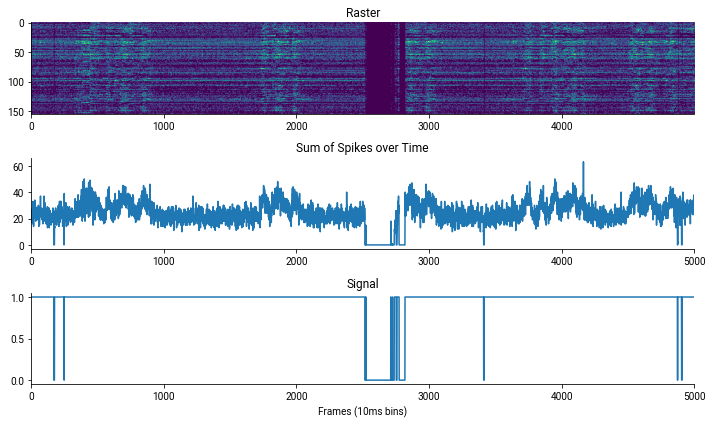

In [11]:
startTime = 1000
endTime = 1050
row = 3
col = 1
plt.figure(figsize=(10,6))
# raster
plt.subplot(row,col,1)
plt.title('Raster')
startBin = time2bin(startTime, lastBin=False, buffer = 0 )
endBin = time2bin(endTime, lastBin=False, buffer = 0 )
t = [ bin2time(x, lastBin=False, buffer = 0) for x in np.arange(startBin,endBin)]
plt.imshow([x[startBin:endBin] for x in data['binnedSpikes']],aspect='auto')
sns.despine()

# sum of spikes over time
plt.subplot(row,col,2)
plt.title('Sum of Spikes over Time')
spikeSum = np.sum([x for x in data['binnedSpikes']],axis=0)
plt.plot(spikeSum[startBin:endBin])
plt.xlim(0,len(t))
sns.despine()

# binarize spike sum over time
plt.subplot(row,col,3)
plt.title('Signal')
val = np.where(spikeSum>0,1,0)
plt.plot(val[startBin:endBin])
plt.xlim(0,len(t))
plt.xlabel('Frames (10ms bins)')

sns.despine()
plt.tight_layout()

print(f'Fraction of Bins dropped: {(len(val)-sum(val))/len(val)}')
print(f"Fraction of Bins dropped, in seconds: {(len(val)-sum(val))*data['binwin']}s out of {len(val)*data['binwin']}s")


### Distribution of Dropout Lengths

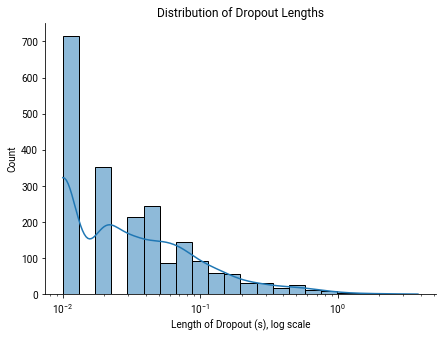

In [9]:
dropout_idx = first_and_last_seq(val,0)
dropout_duration = [((end-start)+1)*data['binwin'] for [start,end] in zip(dropout_idx[0],dropout_idx[1])]
plt.figure(figsize=(7,5))
plt.title('Distribution of Dropout Lengths')
sns.histplot(dropout_duration,log_scale=True,kde=True)
plt.xlabel('Length of Dropout (s), log scale')
sns.despine()


### Distribution of Time Between Dropouts

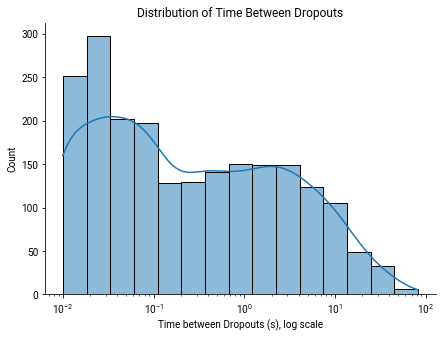

In [10]:
signal_idx = first_and_last_seq(val,1) # to get isi, get distance between dropouts
signal_duration = [((end-start)+1)*data['binwin'] for [start,end] in zip(signal_idx[0],signal_idx[1])]
plt.figure(figsize=(7,5))
plt.title('Distribution of Time Between Dropouts')
sns.histplot(signal_duration,log_scale=True,kde=True)
plt.xlabel('Time between Dropouts (s), log scale')
sns.despine()